### Imports

In [ ]:
import pandas as pd
import json
import os, sys
from tqdm import tqdm
import numpy as np
import polars as pl
from polars import col as c
from pprint import pprint
import matplotlib.pyplot as plt
import re
import shap
import pickle
import git

repo = git.Repo(search_parent_directories=True)

sys.path.append("../")
pl.Config.set_tbl_rows(50)

# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa

# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### constants

In [216]:
FILES_DIR = "../data"
MODELS_DIR = "../models"

In [194]:
icd_feature_map = {
    "disease_I48": "atrial_fibrillation",
    "disease_E04": "nontoxic_goiter",
    "disease_E66": "obesity",
    "disease_I67": "other_cerebrovascular_diseases",
    "disease_I49": "other_cardiac_arrhythmias",
    "disease_I63": "cerebral_infarction",
    "disease_K86": "other_pancreas_diseases",
    "disease_N18": "chronic_kidney_disease",
    "disease_I45": "conduction_disorders",
    "disease_I64": "stroke_unspecified",
    "disease_D64": "other_anemias",
    "disease_K29": "gastritis_duodenitis",
    "disease_J42": "chronic_bronchitis",
    "disease_E03": "other_hypothyroidism",
    "disease_I25": "chronic_ischemic_heart_disease",
    "disease_C18": "colon_cancer",
    "disease_C61": "prostate_cancer",
    "disease_N20": "kidney_ureter_stones",
    "disease_B18": "chronic_viral_hepatitis",
    "disease_D50": "iron_deficiency_anemia",
    "disease_U07": "covid19",
    "disease_I44": "atrioventricular_block",
    "disease_H90": "hearing_loss",
    "disease_C34": "lung_cancer",
    "disease_N28": "other_kidney_ureter_diseases",
    "disease_L40": "psoriasis",
    "disease_I70": "atherosclerosis",
    "disease_N40": "prostate_hyperplasia",
    "disease_J45": "asthma",
    "disease_E74": "other_carbohydrate_metabolism_disorders",
    "disease_I47": "paroxysmal_tachycardia",
    "disease_I69": "cerebrovascular_sequelae",
    "disease_I35": "aortic_valve_disorder",
    "disease_E11": "type2_diabetes",
    "gender": "gender",
    "disease_I71": "aortic_aneurysm",
    "disease_M42": "scheuermann_disease",
    "disease_I11": "hypertensive_heart_disease",
    "disease_E10": "type1_diabetes",
    "disease_E06": "thyroiditis",
    "disease_M10": "gout",
    "disease_K26": "duodenal_ulcer",
    "disease_J44": "copd",
    "disease_K80": "gallstones",
    "disease_K25": "gastric_ulcer",
    "disease_I50": "heart_failure",
    "disease_C50": "breast_cancer",
    "disease_I83": "varicose_veins",
    "disease_I34": "mitral_valve_disorder",
    "disease_G93": "other_brain_disorders",
    "full_wards_killip_class": "killip_class",
}

In [195]:
numerical_feature_map = {
    "full_wards_ecg_right_atrium": "right_atrium",
    "full_wards_ecg_left_atrium": "left_atrium",
    "full_wards_ecg_right_ventricle": "right_ventricle",
    "full_wards_ecg_end_diastolic_volume": "end_diastolic_volume",
    "full_wards_ecg_end_systolic_volume": "end_systolic_volume",
    "full_wards_ecg_stroke_volume": "stroke_volume",
    "full_wards_ecg_ventricular_septal": "ventricular_septal",
    "full_wards_ecg_aorta_diameter_valsalva_sinuses": "aorta_diameter_valsalva_sinuses",
    "full_wards_ecg_age": "age",
    "full_wards_ecg_heart_rate": "heart_rate",
    "full_wards_ecg_ascending_aorta": "ascending_aorta",
    "full_wards_ecg_ejection_fraction": "ejection_fraction",
    "bmi": "bmi",
}

### select data

In [196]:
path = "data_for_models"
os.makedirs(os.path.join(FILES_DIR, path), exist_ok=True)
file_name = "labeled_data_filtered.parquet"
file_path = os.path.join(FILES_DIR, path, file_name)
labeled_data = pl.read_parquet(file_path)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "numerical_cols.pickle"), "rb"
) as f:
    numerical_cols = pickle.load(f)

with open(
    os.path.join(os.path.join(FILES_DIR, path), "discrete_cols.pickle"), "rb"
) as f:
    discrete_cols = pickle.load(f)

In [197]:
labeled_data.sample(2)

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_killip_class,main_disease_I21,main_disease_I20,disease_E03,disease_C34,disease_E06,disease_I47,disease_K25,disease_C50,disease_I35,disease_N20,disease_K29,disease_D50,disease_I70,disease_M10,disease_I50,disease_I71,disease_I69,disease_J42,disease_D64,disease_K86,disease_I25,disease_G93,disease_E66,disease_U07,disease_N40,disease_I67,disease_C61,disease_E11,disease_K80,disease_B18,disease_I11,disease_J44,disease_K26,disease_H90,disease_L40,disease_E10,disease_N18,disease_I63,disease_E04,disease_I48,disease_M42,disease_J45,disease_E74,disease_I64,disease_I49,disease_I34,disease_I45,disease_C18,disease_I83,disease_I44,disease_N28,bmi
date,i64,str,i64,i64,i32,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i32,i32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,f64
2022-06-05,1,"""0965AD66-5C22-4805-B13F-8C3214…",0,0,0,2,0,0,3.5,3.5,3.8,108.0,43.0,55.0,58.0,1.2,3.7,0.5,65.0,72.0,1,0,1,false,false,false,false,false,false,false,false,false,false,true,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,28.0
2024-06-27,1,"""4BE216F6-5995-4387-E055-000000…",0,1,-1,2,0,2,3.7,4.3,3.2,155.0,85.0,70.0,44.0,1.4,3.2,0.3,53.0,55.0,null,1,0,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,28.0


### possible targets

In [198]:
labeled_data["target"].value_counts().sort("count")

target,count
i32,u32
1,473
0,518
-1,6289


In [199]:
labeled_data["main_disease_I21"].value_counts().sort("main_disease_I21")

main_disease_I21,count
i32,u32
null,3
0,3459
1,3818


In [200]:
labeled_data["final_table1_gospitalization_result"].value_counts().sort(
    "final_table1_gospitalization_result"
)

final_table1_gospitalization_result,count
i64,u32
0,6899
1,156
2,8
3,217


### validation metrics

In [201]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    matthews_corrcoef,
    log_loss,
)


def classification_metrics(y_true, y_pred_proba, threshold=0.5):
    """
    Print classification metrics in a pandas DataFrame.

    Parameters:
    - y_true: Ground truth binary labels (0 or 1)
    - y_pred_proba: Predicted probabilities for the positive class
    - threshold: Threshold for converting probabilities to class labels (default = 0.5)
    """
    # Convert predicted probabilities to binary labels
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Compute metrics
    metrics = {
        "ROC_AUC": round(roc_auc_score(y_true, y_pred_proba), 3),
        "PR_AUC": round(average_precision_score(y_true, y_pred_proba), 3),
        "Accuracy": round(accuracy_score(y_true, y_pred), 3),
        "Recall": round(recall_score(y_true, y_pred), 3),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 3),
        "F1": round(f1_score(y_true, y_pred), 3),
        "F2": round(fbeta_score(y_true, y_pred, beta=2), 3),
        "MatthewsCorrCoef": round(matthews_corrcoef(y_true, y_pred), 3),
        "LogLoss": round(log_loss(y_true, y_pred_proba), 3),
    }

    # Convert to DataFrame and print
    metrics_df = pl.DataFrame([metrics])

    return metrics_df

## target - gospitalization_result

### split data

In [202]:
target_gospitalization_result = labeled_data.with_columns(
    c("final_table1_gospitalization_result")
    .replace({2: 1, 3: 1})
    .alias("target_gospitalization_result")
)["target_gospitalization_result"].clone()

# print target ratio
(
    target_gospitalization_result.value_counts()
    .with_columns(
        (c("count") / c("count").sum() * 100).round(2).alias("target_ratio, %")
    )
    .sort("target_gospitalization_result")
)

target_gospitalization_result,count,"target_ratio, %"
i64,u32,f64
0,6899,94.77
1,381,5.23


In [203]:
feature_map = icd_feature_map.copy()
feature_map.update(numerical_feature_map)
print("num of features:", len(feature_map.keys()))
features = labeled_data.rename(feature_map).select(feature_map.values())

num of features: 64


In [204]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target_gospitalization_result,
    stratify=target_gospitalization_result,
    test_size=0.2,
    random_state=2,
)

In [205]:
labeled_data.null_count()

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_killip_class,main_disease_I21,main_disease_I20,disease_E03,disease_C34,disease_E06,disease_I47,disease_K25,disease_C50,disease_I35,disease_N20,disease_K29,disease_D50,disease_I70,disease_M10,disease_I50,disease_I71,disease_I69,disease_J42,disease_D64,disease_K86,disease_I25,disease_G93,disease_E66,disease_U07,disease_N40,disease_I67,disease_C61,disease_E11,disease_K80,disease_B18,disease_I11,disease_J44,disease_K26,disease_H90,disease_L40,disease_E10,disease_N18,disease_I63,disease_E04,disease_I48,disease_M42,disease_J45,disease_E74,disease_I64,disease_I49,disease_I34,disease_I45,disease_C18,disease_I83,disease_I44,disease_N28,bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,69,0,0,343,347,345,535,549,578,684,1156,551,902,74,392,3600,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3087


In [206]:
X_train_cut, X_eval, y_train_cut, y_eval = train_test_split(
    X_train,
    y_train,
    stratify=y_train,
    test_size=0.2,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

### impute data

In [207]:
def mice_imputation_regression_pl(
    df_train: pl.DataFrame,
    df_val: pl.DataFrame,
    df_test: pl.DataFrame,
    numerical_cols: list,
) -> pl.DataFrame:
    """
    Implements MICE imputation using Polars and pandas.

    Args:
        df_train: Polars DataFrame.
        numerical_cols: List of numerical columns to impute.

    Returns:
        Polars DataFrame with imputed values.
    """
    # Convert Polars DataFrame to pandas DataFrame
    df_train_pd = df_train.clone().to_pandas()
    df_val_pd = df_val.clone().to_pandas()
    df_test_pd = df_test.clone().to_pandas()

    # Initialize IterativeImputer
    imputer = IterativeImputer(max_iter=10, random_state=0)

    # Impute missing values in the pandas DataFrame
    df_train_pd[numerical_cols] = imputer.fit_transform(df_train_pd[numerical_cols])
    df_val_pd[numerical_cols] = imputer.transform(df_val_pd[numerical_cols])
    df_test_pd[numerical_cols] = imputer.transform(df_test_pd[numerical_cols])

    # Convert the imputed pandas DataFrame back to Polars DataFrame
    df_train_pl = pl.from_pandas(df_train_pd)
    df_val_pl = pl.from_pandas(df_val_pd)
    df_test_pl = pl.from_pandas(df_test_pd)

    return df_train_pl, df_val_pl, df_test_pl


X_train_cut, X_eval, X_test = mice_imputation_regression_pl(
    df_train=X_train_cut,
    df_val=X_eval,
    df_test=X_test,
    numerical_cols=list(numerical_feature_map.values()),
)

/Users/konstantinburkin/Documents/hse_projects/parse-records/.venv/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [208]:
def mice_imputation_classification_pl(
    df_train: pl.DataFrame,
    df_val: pl.DataFrame,
    df_test: pl.DataFrame,
    discrete_cols: list,
) -> pl.DataFrame:
    """
    Implements MICE imputation using Polars and pandas.

    Args:
        df: Polars DataFrame.
        discrete_cols: List of numerical columns to impute.

    Returns:
        Polars DataFrame with imputed values.
    """
    # Convert Polars DataFrame to pandas DataFrame
    df_train_pd = df_train.clone().to_pandas()
    df_val_pd = df_val.clone().to_pandas()
    df_test_pd = df_test.clone().to_pandas()

    # Initialize IterativeImputer
    imputer = IterativeImputer(
        max_iter=10, random_state=0, estimator=LogisticRegression()
    )

    # Impute missing values in the pandas DataFrame
    df_train_pd[discrete_cols] = imputer.fit_transform(df_train_pd[discrete_cols])
    df_val_pd[discrete_cols] = imputer.transform(df_val_pd[discrete_cols])
    df_test_pd[discrete_cols] = imputer.transform(df_test_pd[discrete_cols])

    # Convert the imputed pandas DataFrame back to Polars DataFrame
    df_train_pl = pl.from_pandas(df_train_pd)
    df_val_pl = pl.from_pandas(df_val_pd)
    df_test_pl = pl.from_pandas(df_test_pd)

    return df_train_pl, df_val_pl, df_test_pl


X_train_cut = X_train_cut.with_columns(
    (c(col) * 1.0) for col in list(icd_feature_map.values())
)
X_eval = X_eval.with_columns((c(col) * 1.0) for col in list(icd_feature_map.values()))
X_test = X_test.with_columns((c(col) * 1.0) for col in list(icd_feature_map.values()))

X_train_cut, X_eval, X_test = mice_imputation_classification_pl(
    df_train=X_train_cut,
    df_val=X_eval,
    df_test=X_test,
    discrete_cols=list(icd_feature_map.values()),
)


X_train_cut = X_train_cut.with_columns(
    (c(col).cast(pl.Int64)) for col in list(icd_feature_map.values())
)
X_eval = X_eval.with_columns(
    (c(col).cast(pl.Int64)) for col in list(icd_feature_map.values())
)
X_test = X_test.with_columns(
    (c(col).cast(pl.Int64)) for col in list(icd_feature_map.values())
)

In [209]:
labeled_data.null_count()  # Verify that null counts are reduced

admission_datetime,gender,patient_id,gospitalisation_type,gospitalisation_delivery,target,final_table1_main_desease_status,final_table1_gospitalization_result,condition_status,full_wards_ecg_right_atrium,full_wards_ecg_left_atrium,full_wards_ecg_right_ventricle,full_wards_ecg_end_diastolic_volume,full_wards_ecg_end_systolic_volume,full_wards_ecg_stroke_volume,full_wards_ecg_ejection_fraction,full_wards_ecg_ventricular_septal,full_wards_ecg_aorta_diameter_valsalva_sinuses,full_wards_ecg_ascending_aorta,full_wards_ecg_age,full_wards_ecg_heart_rate,full_wards_killip_class,main_disease_I21,main_disease_I20,disease_E03,disease_C34,disease_E06,disease_I47,disease_K25,disease_C50,disease_I35,disease_N20,disease_K29,disease_D50,disease_I70,disease_M10,disease_I50,disease_I71,disease_I69,disease_J42,disease_D64,disease_K86,disease_I25,disease_G93,disease_E66,disease_U07,disease_N40,disease_I67,disease_C61,disease_E11,disease_K80,disease_B18,disease_I11,disease_J44,disease_K26,disease_H90,disease_L40,disease_E10,disease_N18,disease_I63,disease_E04,disease_I48,disease_M42,disease_J45,disease_E74,disease_I64,disease_I49,disease_I34,disease_I45,disease_C18,disease_I83,disease_I44,disease_N28,bmi
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,69,0,0,343,347,345,535,549,578,684,1156,551,902,74,392,3600,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3087


### base prediction - mean

In [210]:
preds = y_test.shape[0] * [y_train.mean()]
print("base prediction:", preds[0])

base prediction: 0.052369505494505496


In [211]:
# roc_auc_score(y_test, preds)
display(classification_metrics(y_test, np.array(preds)))

ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.5,0.052,0.948,0.0,0.0,0.0,0.0,0.0,0.205


### test initial catboost model

In [212]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score


def objective(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000, step=100),
        "depth": trial.suggest_int("depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.5, 5.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_seed": 2024,
        "eval_metric": "AUC",
        "loss_function": "Logloss",
        "verbose": 0,
        "task_type": "CPU",  # Use "GPU" if available and desired
        "early_stopping_rounds": 50,
        "thread_count": -1,
        "cat_features": list(icd_feature_map.values()),
    }

    # Create CatBoost model
    model = CatBoostClassifier(**params)

    # Fit model with early stopping
    model.fit(
        X=X_train_cut.to_pandas(),
        y=y_train_cut.to_pandas(),
        early_stopping_rounds=50,
        verbose=25,
        eval_set=(
            X_eval.to_pandas(),
            y_eval.to_pandas(),
        ),
    )

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_eval.to_pandas())[:, 1]

    # Calculate ROC AUC
    auc_score = roc_auc_score(y_eval.to_pandas(), y_pred_proba)

    return auc_score


# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Results
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

[I 2025-07-25 09:10:40,818] A new study created in memory with name: no-name-4739b73f-8bcb-459a-a28e-d568c01be3f7


0:	test: 0.5416889	best: 0.5416889 (0)	total: 5.71ms	remaining: 3.42s
25:	test: 0.6827928	best: 0.6894007 (7)	total: 109ms	remaining: 2.41s
50:	test: 0.7182377	best: 0.7188317 (49)	total: 212ms	remaining: 2.28s
75:	test: 0.7211036	best: 0.7233458 (58)	total: 319ms	remaining: 2.2s
100:	test: 0.7241180	best: 0.7249495 (97)	total: 419ms	remaining: 2.07s
125:	test: 0.7251871	best: 0.7259296 (113)	total: 531ms	remaining: 2s
150:	test: 0.7264196	best: 0.7278005 (146)	total: 636ms	remaining: 1.89s
175:	test: 0.7267166	best: 0.7282609 (163)	total: 742ms	remaining: 1.79s


[I 2025-07-25 09:10:41,853] Trial 0 finished with value: 0.7282608695652174 and parameters: {'iterations': 600, 'depth': 3, 'learning_rate': 0.030879310610674955, 'l2_leaf_reg': 3.7708057719051755, 'border_count': 128, 'random_strength': 3.0636397149001273, 'bagging_temperature': 0.004964660627415851}. Best is trial 0 with value: 0.7282608695652174.


200:	test: 0.7248901	best: 0.7282609 (163)	total: 842ms	remaining: 1.67s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7282608696
bestIteration = 163

Shrink model to first 164 iterations.
0:	test: 0.6090595	best: 0.6090595 (0)	total: 6.62ms	remaining: 4.63s
25:	test: 0.6955705	best: 0.7100558 (7)	total: 139ms	remaining: 3.61s
50:	test: 0.6802239	best: 0.7100558 (7)	total: 284ms	remaining: 3.61s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7100558327
bestIteration = 7

Shrink model to first 8 iterations.


[I 2025-07-25 09:10:42,288] Trial 1 finished with value: 0.710055832739368 and parameters: {'iterations': 700, 'depth': 6, 'learning_rate': 0.2598716992077075, 'l2_leaf_reg': 6.978351169918406, 'border_count': 196, 'random_strength': 2.810075816502107, 'bagging_temperature': 0.48174074871601724}. Best is trial 0 with value: 0.7282608695652174.


0:	test: 0.5839050	best: 0.5839050 (0)	total: 9.38ms	remaining: 6.56s
25:	test: 0.6887770	best: 0.6922443 (12)	total: 205ms	remaining: 5.31s
50:	test: 0.7188911	best: 0.7191435 (49)	total: 405ms	remaining: 5.15s
75:	test: 0.7192029	best: 0.7216976 (55)	total: 622ms	remaining: 5.11s
100:	test: 0.7189505	best: 0.7228706 (79)	total: 855ms	remaining: 5.07s


[I 2025-07-25 09:10:43,508] Trial 2 finished with value: 0.7228706343549537 and parameters: {'iterations': 700, 'depth': 8, 'learning_rate': 0.03142192122420258, 'l2_leaf_reg': 1.410659693769002, 'border_count': 189, 'random_strength': 4.795516022658543, 'bagging_temperature': 0.746589235266685}. Best is trial 0 with value: 0.7282608695652174.


125:	test: 0.7110804	best: 0.7228706 (79)	total: 1.07s	remaining: 4.9s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7228706344
bestIteration = 79

Shrink model to first 80 iterations.
0:	test: 0.5840090	best: 0.5840090 (0)	total: 9.53ms	remaining: 2.85s
25:	test: 0.6774174	best: 0.6774174 (25)	total: 215ms	remaining: 2.27s
50:	test: 0.6880865	best: 0.6921552 (39)	total: 433ms	remaining: 2.11s


[I 2025-07-25 09:10:44,430] Trial 3 finished with value: 0.6921552031361369 and parameters: {'iterations': 300, 'depth': 8, 'learning_rate': 0.09226813399747566, 'l2_leaf_reg': 4.291211886130842, 'border_count': 217, 'random_strength': 2.0969916928999823, 'bagging_temperature': 0.2920932642337284}. Best is trial 0 with value: 0.7282608695652174.


75:	test: 0.6788133	best: 0.6921552 (39)	total: 671ms	remaining: 1.98s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6921552031
bestIteration = 39

Shrink model to first 40 iterations.
0:	test: 0.5923542	best: 0.5923542 (0)	total: 4.69ms	remaining: 2.34s
25:	test: 0.7096178	best: 0.7170572 (19)	total: 97.8ms	remaining: 1.78s
50:	test: 0.7138498	best: 0.7170572 (19)	total: 200ms	remaining: 1.76s


[I 2025-07-25 09:10:45,013] Trial 4 finished with value: 0.7173096341173675 and parameters: {'iterations': 500, 'depth': 4, 'learning_rate': 0.11326610628467364, 'l2_leaf_reg': 2.7351427194005002, 'border_count': 250, 'random_strength': 4.058218425776236, 'bagging_temperature': 0.08206221346551401}. Best is trial 0 with value: 0.7282608695652174.


75:	test: 0.7124391	best: 0.7173096 (55)	total: 308ms	remaining: 1.72s
100:	test: 0.7084892	best: 0.7173096 (55)	total: 433ms	remaining: 1.71s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7173096341
bestIteration = 55

Shrink model to first 56 iterations.
0:	test: 0.5633984	best: 0.5633984 (0)	total: 4.41ms	remaining: 3.08s
25:	test: 0.7046062	best: 0.7046062 (25)	total: 114ms	remaining: 2.95s
50:	test: 0.7182080	best: 0.7224549 (45)	total: 220ms	remaining: 2.8s
75:	test: 0.7216753	best: 0.7246154 (69)	total: 344ms	remaining: 2.83s


[I 2025-07-25 09:10:45,892] Trial 5 finished with value: 0.7246154074602043 and parameters: {'iterations': 700, 'depth': 4, 'learning_rate': 0.0611868553900405, 'l2_leaf_reg': 5.29358137476795, 'border_count': 134, 'random_strength': 3.6451312369370643, 'bagging_temperature': 0.38497091466955846}. Best is trial 0 with value: 0.7282608695652174.


100:	test: 0.7177922	best: 0.7246154 (69)	total: 459ms	remaining: 2.72s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7246154075
bestIteration = 69

Shrink model to first 70 iterations.
0:	test: 0.6121110	best: 0.6121110 (0)	total: 4.3ms	remaining: 3.87s
25:	test: 0.7162182	best: 0.7241031 (24)	total: 111ms	remaining: 3.74s


[I 2025-07-25 09:10:46,372] Trial 6 finished with value: 0.7281866239011641 and parameters: {'iterations': 900, 'depth': 5, 'learning_rate': 0.016997264136203172, 'l2_leaf_reg': 4.891615626450345, 'border_count': 204, 'random_strength': 2.9828847701283197, 'bagging_temperature': 0.2609327783086888}. Best is trial 0 with value: 0.7282608695652174.


50:	test: 0.7198266	best: 0.7281866 (39)	total: 211ms	remaining: 3.51s
75:	test: 0.7117783	best: 0.7281866 (39)	total: 312ms	remaining: 3.38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7281866239
bestIteration = 39

Shrink model to first 40 iterations.
0:	test: 0.6258761	best: 0.6258761 (0)	total: 5.99ms	remaining: 4.78s
25:	test: 0.6891928	best: 0.6899947 (24)	total: 139ms	remaining: 4.13s
50:	test: 0.7072048	best: 0.7072048 (50)	total: 271ms	remaining: 3.99s
75:	test: 0.7184159	best: 0.7198563 (59)	total: 444ms	remaining: 4.22s
100:	test: 0.7237913	best: 0.7250089 (99)	total: 1.07s	remaining: 7.39s
125:	test: 0.7182229	best: 0.7255732 (105)	total: 2.03s	remaining: 10.9s


[I 2025-07-25 09:10:48,795] Trial 7 finished with value: 0.7255731765264909 and parameters: {'iterations': 800, 'depth': 7, 'learning_rate': 0.039046206569784275, 'l2_leaf_reg': 6.862747557574963, 'border_count': 95, 'random_strength': 4.047610851429138, 'bagging_temperature': 0.8182822769256995}. Best is trial 0 with value: 0.7282608695652174.


150:	test: 0.7111547	best: 0.7255732 (105)	total: 2.23s	remaining: 9.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7255731765
bestIteration = 105

Shrink model to first 106 iterations.
0:	test: 0.6067059	best: 0.6067059 (0)	total: 8.29ms	remaining: 4.14s
25:	test: 0.7041088	best: 0.7059352 (24)	total: 276ms	remaining: 5.02s
50:	test: 0.6978944	best: 0.7059352 (24)	total: 510ms	remaining: 4.49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7059351984
bestIteration = 24

Shrink model to first 25 iterations.


[I 2025-07-25 09:10:49,633] Trial 8 finished with value: 0.7059351983844144 and parameters: {'iterations': 500, 'depth': 7, 'learning_rate': 0.18627319763340425, 'l2_leaf_reg': 4.410979147023123, 'border_count': 41, 'random_strength': 3.0746315145643566, 'bagging_temperature': 0.1935943492279516}. Best is trial 0 with value: 0.7282608695652174.


0:	test: 0.6149843	best: 0.6149843 (0)	total: 3.76ms	remaining: 3.76s
25:	test: 0.7086971	best: 0.7151194 (3)	total: 100ms	remaining: 3.76s


[I 2025-07-25 09:10:49,980] Trial 9 finished with value: 0.7151193870277975 and parameters: {'iterations': 1000, 'depth': 4, 'learning_rate': 0.156347300551157, 'l2_leaf_reg': 3.4538027836329093, 'border_count': 177, 'random_strength': 2.239449943347884, 'bagging_temperature': 0.9323763957799119}. Best is trial 0 with value: 0.7282608695652174.


50:	test: 0.6971222	best: 0.7151194 (3)	total: 223ms	remaining: 4.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.715119387
bestIteration = 3

Shrink model to first 4 iterations.
Best hyperparameters: {'iterations': 600, 'depth': 3, 'learning_rate': 0.030879310610674955, 'l2_leaf_reg': 3.7708057719051755, 'border_count': 128, 'random_strength': 3.0636397149001273, 'bagging_temperature': 0.004964660627415851}
Best AUC score: 0.7282608695652174


In [150]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=list(icd_feature_map.values()),
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)

model.fit(
    X=X_train_cut.to_pandas(),
    y=y_train_cut.to_pandas(),
    early_stopping_rounds=50,
    verbose=25,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

display(classification_metrics(y_test, model.predict_proba(X_test.to_pandas())[:, 1]))

0:	test: 0.4876678	best: 0.4876678 (0)	total: 5.7ms	remaining: 1.42s
25:	test: 0.7298275	best: 0.7311045 (12)	total: 108ms	remaining: 932ms
50:	test: 0.7362646	best: 0.7367843 (48)	total: 212ms	remaining: 826ms
75:	test: 0.7364576	best: 0.7378237 (68)	total: 308ms	remaining: 706ms
100:	test: 0.7361161	best: 0.7378237 (68)	total: 411ms	remaining: 606ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7378237111
bestIteration = 68

Shrink model to first 69 iterations.


ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.758,0.378,0.955,0.25,0.704,0.369,0.287,0.403,0.164


In [176]:
study.best_params

{'iterations': 1000,
 'depth': 5,
 'learning_rate': 0.19652633605985076,
 'l2_leaf_reg': 3.3167656712408204,
 'border_count': 113,
 'random_strength': 4.7701173935747185,
 'bagging_temperature': 0.40678193940442176}

In [229]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=list(icd_feature_map.values()),
    eval_metric="AUC",
    **study.best_params,
)

model.fit(
    X=X_train_cut.to_pandas(),
    y=y_train_cut.to_pandas(),
    early_stopping_rounds=50,
    verbose=25,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

display(classification_metrics(y_test, model.predict_proba(X_test.to_pandas())[:, 1]))

0:	test: 0.5416889	best: 0.5416889 (0)	total: 5.32ms	remaining: 3.19s
25:	test: 0.6827928	best: 0.6894007 (7)	total: 116ms	remaining: 2.55s
50:	test: 0.7182377	best: 0.7188317 (49)	total: 194ms	remaining: 2.09s
75:	test: 0.7211036	best: 0.7233458 (58)	total: 281ms	remaining: 1.94s
100:	test: 0.7241180	best: 0.7249495 (97)	total: 361ms	remaining: 1.78s
125:	test: 0.7251871	best: 0.7259296 (113)	total: 436ms	remaining: 1.64s
150:	test: 0.7264196	best: 0.7278005 (146)	total: 511ms	remaining: 1.52s
175:	test: 0.7267166	best: 0.7282609 (163)	total: 595ms	remaining: 1.43s
200:	test: 0.7248901	best: 0.7282609 (163)	total: 677ms	remaining: 1.34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7282608696
bestIteration = 163

Shrink model to first 164 iterations.


ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.745,0.196,0.948,0.0,0.0,0.0,0.0,0.0,0.185


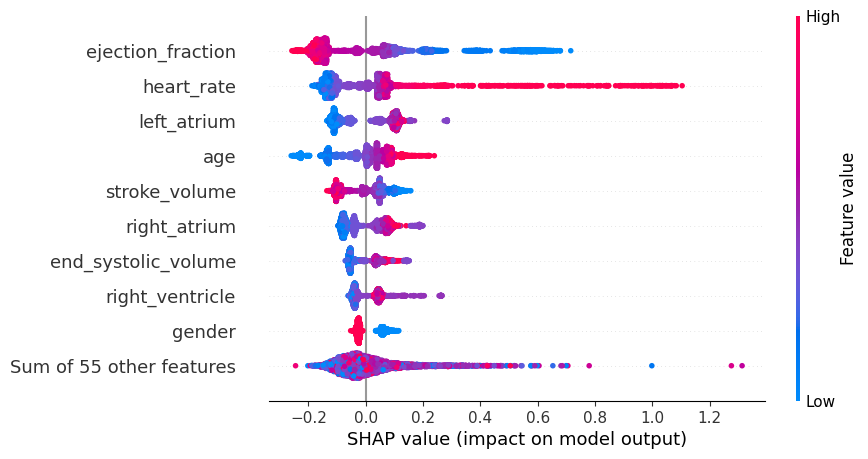

In [230]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_cut.to_pandas())
shap.plots.beeswarm(
    shap_values,
    plot_size=(8, 5),
)
plt.show()

In [228]:
# save model
os.makedirs(os.path.join(MODELS_DIR, repo.head.object.hexsha[:8]), exist_ok=True)
file_name = "catboost.cbm"
file_path = os.path.join(MODELS_DIR, repo.head.object.hexsha[:8], file_name)
model.save_model(file_path)

### overfit model on small batch

In [227]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=list(icd_feature_map.values()),
    eval_metric="AUC",
    **study.best_params,
)

model.fit(
    X=X_eval.to_pandas(),
    y=y_eval.to_pandas(),
    # early_stopping_rounds=50,
    verbose=25,
    # eval_set=(
    #     X_eval.to_pandas(),
    #     y_eval.to_pandas(),
    # ),
)

display(classification_metrics(y_eval, model.predict_proba(X_eval.to_pandas())[:, 1]))

0:	total: 6.04ms	remaining: 3.62s
25:	total: 48.3ms	remaining: 1.07s
50:	total: 82.5ms	remaining: 888ms
75:	total: 116ms	remaining: 798ms
100:	total: 149ms	remaining: 738ms
125:	total: 183ms	remaining: 689ms
150:	total: 218ms	remaining: 648ms
175:	total: 256ms	remaining: 616ms
200:	total: 291ms	remaining: 577ms
225:	total: 328ms	remaining: 543ms
250:	total: 368ms	remaining: 512ms
275:	total: 407ms	remaining: 478ms
300:	total: 444ms	remaining: 441ms
325:	total: 476ms	remaining: 400ms
350:	total: 509ms	remaining: 361ms
375:	total: 543ms	remaining: 324ms
400:	total: 575ms	remaining: 285ms
425:	total: 609ms	remaining: 249ms
450:	total: 644ms	remaining: 213ms
475:	total: 784ms	remaining: 204ms
500:	total: 826ms	remaining: 163ms
525:	total: 866ms	remaining: 122ms
550:	total: 906ms	remaining: 80.6ms
575:	total: 943ms	remaining: 39.3ms
599:	total: 977ms	remaining: 0us


ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.96,0.796,0.965,0.328,1.0,0.494,0.379,0.562,0.109


### model evaluation with LIME and SHAP

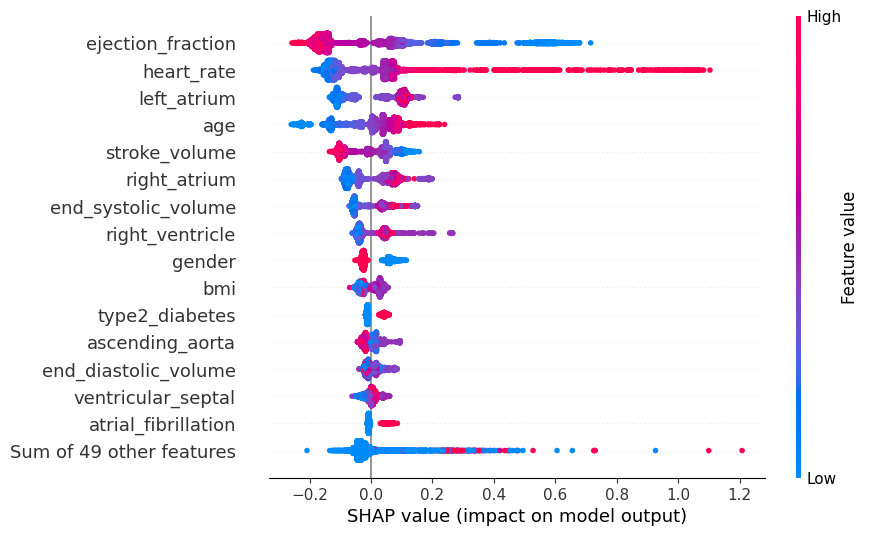

In [231]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train_cut.to_pandas())
shap.plots.beeswarm(
    shap_values,
    16,
    plot_size=(8, 6),
)
plt.show()

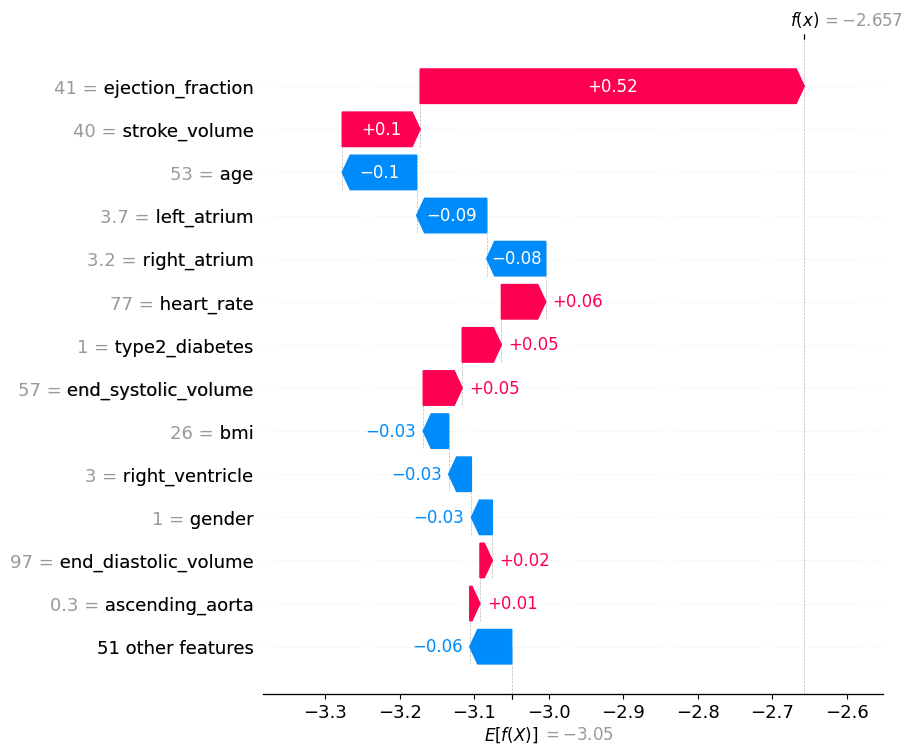

In [232]:
shap.plots.waterfall(shap_values[0], max_display=14)

/var/folders/yt/5rqq39t16xs0vjb7z99vs0cw0000gn/T/ipykernel_3968/2259574278.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


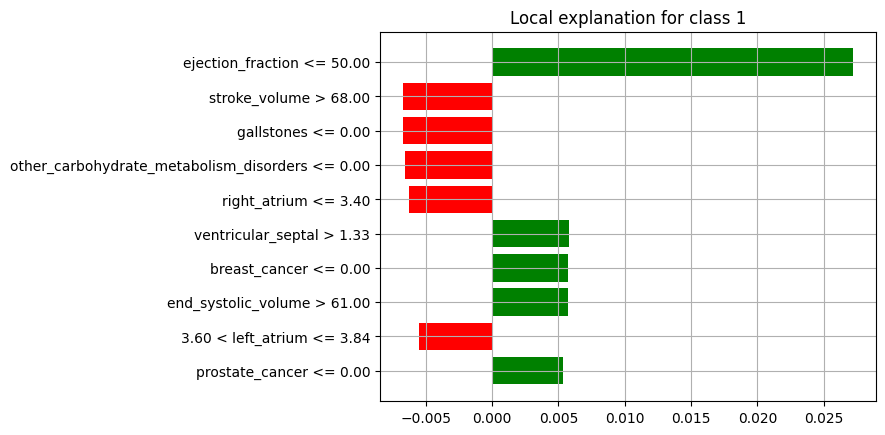

In [241]:
import lime

import lime.lime_tabular

# Initialize the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_cut.to_pandas().values,
    feature_names=X_train_cut.columns,
    class_names=["0", "1"],
    mode="classification",
)


def lime_predict_fn(x):
    # x is a numpy array, shape (n, features)
    # Convert to DataFrame with correct columns and dtypes
    df = pd.DataFrame(x, columns=X_train_cut.columns)
    # If you have categorical columns, cast them to the correct dtype
    for col in list(icd_feature_map.values()):
        df[col] = df[col].astype(X_train_cut[col].to_pandas().dtype)
    return model.predict_proba(df)


def explain_instance(instance, model, num_features=10):
    explanation = explainer.explain_instance(
        data_row=instance.values,
        predict_fn=lime_predict_fn,
        # num_features=num_features,
    )
    return explanation


# Example usage: Explain the first instance in the test set
instance_to_explain = X_test.to_pandas().iloc[4]
explanation = explain_instance(instance_to_explain, model)
fig = explanation.as_pyplot_figure()
plt.grid()
fig.show()

### random forest

In [242]:
def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 200, 800, step=100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    #     criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    # Train the Random Forest model with the suggested hyperparameters
    rf_model = RandomForestClassifier(
        random_state=2024,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        #         criterion=criterion,
        n_jobs=-1,
    )
    rf_model.fit(X_train_cut, y_train_cut.to_pandas())

    # Evaluate the model
    y_pred_proba_rf = rf_model.predict_proba(X_eval)[:, 1]
    auc_score_rf = roc_auc_score(y_eval.to_pandas(), y_pred_proba_rf)

    return auc_score_rf


# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Print the best hyperparameters and the corresponding AUC score
print("Best hyperparameters:", study.best_params)
print("Best AUC score:", study.best_value)

[I 2025-07-25 09:34:49,288] A new study created in memory with name: no-name-6e7e839d-5114-416d-9344-33f7110619c1
[I 2025-07-25 09:34:50,394] Trial 0 finished with value: 0.7112586124970303 and parameters: {'n_estimators': 500, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7112586124970303.
[I 2025-07-25 09:34:51,369] Trial 1 finished with value: 0.7044131622713233 and parameters: {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7112586124970303.
[I 2025-07-25 09:34:51,776] Trial 2 finished with value: 0.7116149916844856 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7116149916844856.
[I 2025-07-25 09:34:53,390] Trial 3 finished with value: 0.7110655737704918 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 2 with value: 

Best hyperparameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4}
Best AUC score: 0.7116149916844856


In [ ]:
pl.concat([X_train_cut, X_eval]).to_pandas()

In [ ]:
pl.concat([y_train_cut, y_eval]).to_pandas()

In [248]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=2024,
    # n_estimators=500,
    # max_depth=5,
    **study.best_params,
)  # You can adjust hyperparameters as needed
rf_model.fit(
    pl.concat([X_train_cut, X_eval]).to_pandas(),
    pl.concat([y_train_cut, y_eval]).to_pandas(),
)

# Evaluate the model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
display(classification_metrics(y_test, y_pred_proba_rf))

ROC_AUC,PR_AUC,Accuracy,Recall,Precision,F1,F2,MatthewsCorrCoef,LogLoss
f64,f64,f64,f64,f64,f64,f64,f64,f64
0.753,0.215,0.948,0.0,0.0,0.0,0.0,0.0,0.179


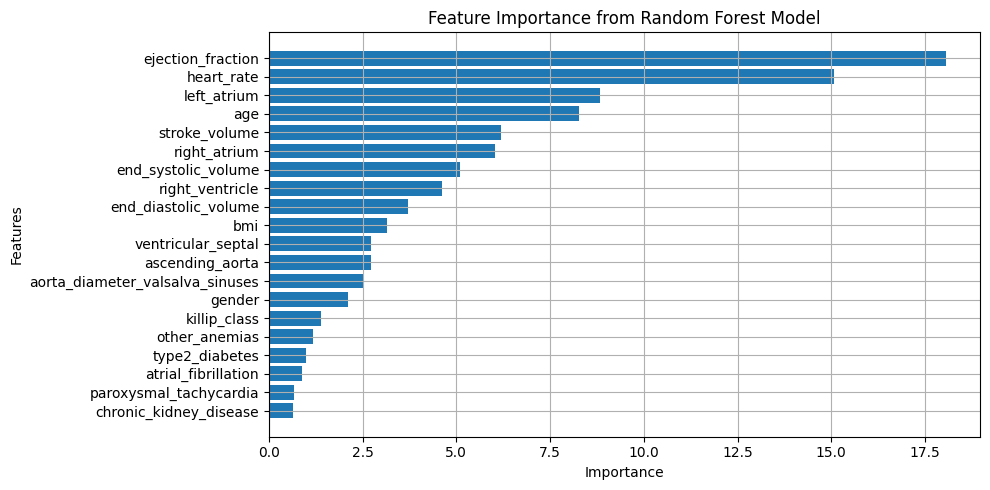

In [249]:
feature_importance = (
    pd.DataFrame({"feature": X_train.columns, "importance": model.feature_importances_})
    .sort_values("importance", ascending=True)
    .tail(20)
)

plt.figure(figsize=(10, 5))
plt.barh(
    feature_importance["feature"],
    feature_importance["importance"],
)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance from Random Forest Model")
plt.tight_layout()
plt.grid()
plt.show()

### linear regression

In [264]:
X_train_cut.shape

(4659, 64)

In [263]:
X_train_scaled.shape

(4659, 64)

In [265]:
X_train_scaled_pd.shape

(4659, 13)

In [266]:
X_train_pd.shape

(4659, 51)

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = pl.concat([X_train_cut, X_eval]).with_columns(
    [c(col).cast(pl.Float64) for col in numerical_feature_map.values()]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_feature_map.values()])
X_test_scaled = X_test.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_feature_map.values()]
)

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(
        X_train_scaled.select(numerical_feature_map.values()).to_pandas()
    ),
    columns=numerical_feature_map.values(),
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_feature_map.values()).to_pandas()),
#     columns=numerical_feature_map.values(),
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_feature_map.values()).to_pandas()),
    columns=numerical_feature_map.values(),
)

X_train_pd = (
    pl.concat([X_train_cut, X_eval])
    .to_pandas()
    .drop(columns=numerical_feature_map.values())
)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_feature_map.values())
X_test_pd = X_test.to_pandas().drop(columns=numerical_feature_map.values())

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)
logistic_model.fit(X_train_scaled_final, pl.concat([y_train_cut, y_eval]).to_pandas())

# Evaluate the model
y_pred_proba = logistic_model.predict_proba(X_test_scaled_final)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score: {auc_score:.3f}")

AUC Score: 0.714


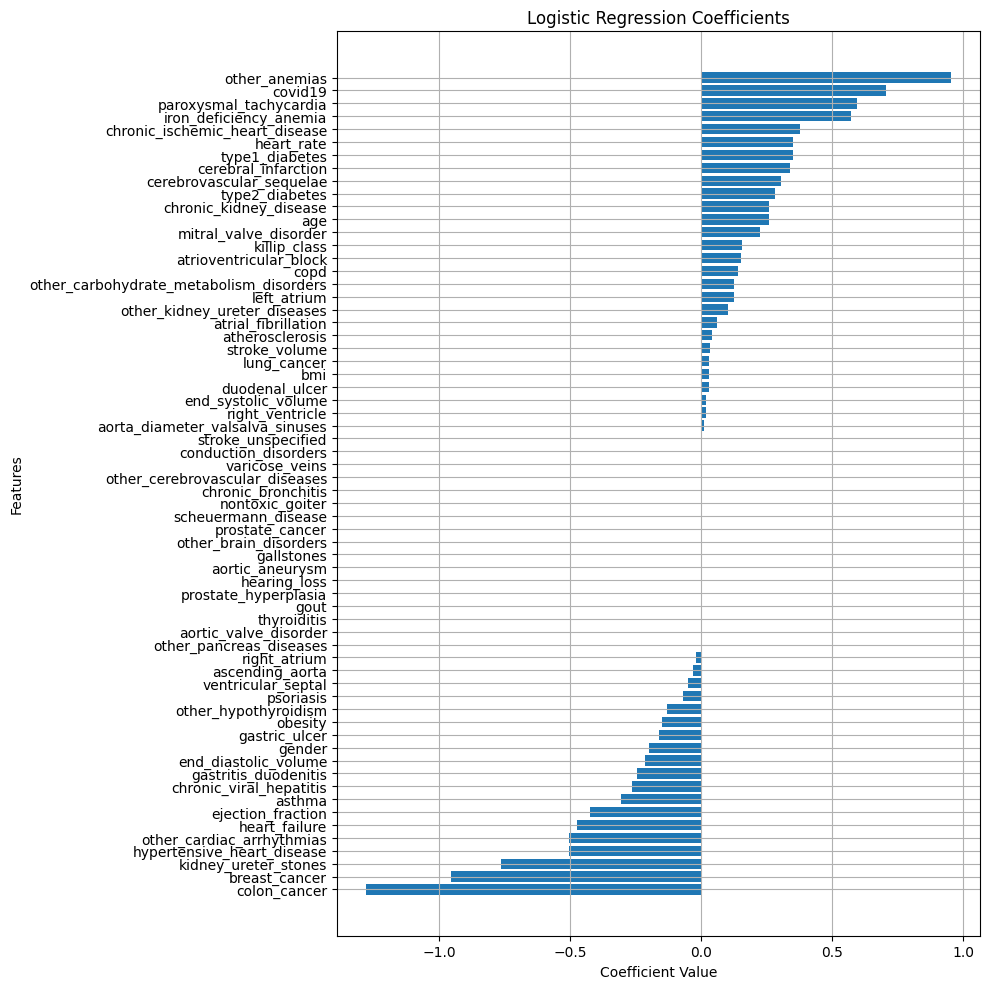

In [269]:
coefficients = pd.DataFrame(
    {
        "feature": X_train_scaled_final.columns,
        "coefficient": logistic_model.coef_[0],
    }
).sort_values("coefficient", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(
    coefficients["feature"],
    coefficients["coefficient"],
)
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.title("Logistic Regression Coefficients")
plt.tight_layout()
plt.grid()
plt.show()

## target - main desease I20/I21
TODO

### split data

In [144]:
known_target = labeled_data.filter(c("target") != -1)

In [145]:
# sorted(discrete_cols_without_main_disease)

discrete_cols_cut = [
    "condition_status",
    "final_table1_gospitalization_result",
    "final_table1_main_desease_status",
    "gender",
    "gospitalisation_delivery",
    "gospitalisation_type",
    "main_disease_I21",
]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(
    known_target.select(discrete_cols_cut + numerical_cols),
    known_target["target"],
    test_size=0.2,
    random_state=2,
)

In [147]:
X_train_cut, X_eval, y_train_cut, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=1,
)  # 0.25 x 0.8 = 0.2

In [148]:
missing_target = labeled_data.filter(c("target") == -1)

In [149]:
X_train = pl.concat([X_train, missing_target.select(X_train.columns)])
y_train = pl.concat(
    [
        y_train.cast(pl.Int64),
        pl.Series("target", [-1] * missing_target.height).cast(pl.Int64),
    ]
)

In [150]:
# cat_cols = X_train.select(
#     pl.selectors.by_dtype(pl.String),
# ).columns

### log reg

In [167]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_cols]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])
X_test_scaled = X_test.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(X_train_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_cols).to_pandas()),
#     columns=numerical_cols,
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)

X_train_pd = X_train.to_pandas().drop(columns=numerical_cols)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_cols)
X_test_pd = X_test.to_pandas().drop(columns=numerical_cols)

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)


self_training_model = SelfTrainingClassifier(
    logistic_model,
    verbose=1,
    criterion="threshold",
    threshold=0.85,
    max_iter=5,
)

self_training_model.fit(X_train, y_train.to_pandas())

y_pred_proba = self_training_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score (SelfTrainingClassifier with RandomForest): {auc_score:.3f}")

End of iteration 1, added 289 new labels.
End of iteration 2, added 801 new labels.
End of iteration 3, added 638 new labels.
End of iteration 4, added 738 new labels.
End of iteration 5, added 703 new labels.
AUC Score (SelfTrainingClassifier with RandomForest): 0.808


In [ ]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = X_train.with_columns(
    [c(col).cast(pl.Float64) for col in numerical_cols]
)
# X_eval_scaled = X_eval.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])
X_test_scaled = X_test.with_columns([c(col).cast(pl.Float64) for col in numerical_cols])

X_train_scaled_pd = pd.DataFrame(
    scaler.fit_transform(X_train_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)
# X_eval_scaled_pd = pd.DataFrame(
#     scaler.transform(X_eval_scaled.select(numerical_cols).to_pandas()),
#     columns=numerical_cols,
# )
X_test_scaled_pd = pd.DataFrame(
    scaler.transform(X_test_scaled.select(numerical_cols).to_pandas()),
    columns=numerical_cols,
)

X_train_pd = X_train.to_pandas().drop(columns=numerical_cols)
# X_eval_pd = X_eval.to_pandas().drop(columns=numerical_cols)
X_test_pd = X_test.to_pandas().drop(columns=numerical_cols)

X_train_scaled_final = pd.concat([X_train_scaled_pd, X_train_pd], axis=1)
# X_eval_scaled_final = pd.concat([X_eval_scaled_pd, X_eval_pd], axis=1)
X_test_scaled_final = pd.concat([X_test_scaled_pd, X_test_pd], axis=1)


# Train Logistic Regression model
logistic_model = LogisticRegression(
    random_state=2024,
    solver="liblinear",
    penalty="l1",
)

logistic_model.fit(
    X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas()
)

# Evaluate the model
y_pred_proba_rf = logistic_model.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

AUC Score (Random Forest): 0.806


### random forest

In [62]:
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier

In [185]:
rf_model = RandomForestClassifier(
    random_state=2024,
    n_estimators=500,
    n_jobs=-1,
    verbose=0,
    max_depth=5,
)


self_training_model = SelfTrainingClassifier(
    rf_model,
    verbose=1,
    criterion="threshold",
    threshold=0.82,
    max_iter=5,
)

self_training_model.fit(X_train, y_train.to_pandas())

y_pred_proba = self_training_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score (SelfTrainingClassifier with RandomForest): {auc_score:.4f}")

End of iteration 1, added 3 new labels.
End of iteration 2, added 5 new labels.
End of iteration 3, added 23 new labels.
End of iteration 4, added 66 new labels.
End of iteration 5, added 79 new labels.
AUC Score (SelfTrainingClassifier with RandomForest): 0.7992


In [169]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    random_state=2024,
    n_estimators=500,
    n_jobs=-1,
    verbose=0,
    max_depth=5,
)
rf_model.fit(X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas())

# Evaluate the model
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.4f}")

AUC Score (Random Forest): 0.7930


### catboost

In [173]:
model = CatBoostClassifier(
    random_seed=2024,
    # cat_features=[X_train.columns.index(col) for col in discrete_cols_cut],
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
    verbose=0,
)


self_training_model = SelfTrainingClassifier(
    model,
    verbose=1,
    criterion="threshold",
    threshold=0.85,
    max_iter=7,
)

self_training_model.fit(X_train.to_pandas(), y_train.to_pandas())

y_pred_proba = self_training_model.predict_proba(X_test.to_pandas())[:, 1]
auc_score = roc_auc_score(y_test.to_pandas(), y_pred_proba)

print(f"AUC Score (SelfTrainingClassifier with RandomForest): {auc_score:.3f}")

End of iteration 1, added 442 new labels.
End of iteration 2, added 1138 new labels.
End of iteration 3, added 1109 new labels.
End of iteration 4, added 724 new labels.
End of iteration 5, added 352 new labels.
End of iteration 6, added 99 new labels.
End of iteration 7, added 85 new labels.
AUC Score (SelfTrainingClassifier with RandomForest): 0.808


In [108]:
# Train CatBoostClassifier model
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)
# model.fit(X_train, y_train.to_pandas())

model.fit(
    X=X_train_cut.to_pandas(),
    y=y_train_cut.to_pandas(),
    early_stopping_rounds=50,
    verbose=5,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test.to_pandas())[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

0:	test: 0.6423688	best: 0.6423688 (0)	total: 2.04ms	remaining: 509ms
5:	test: 0.7195548	best: 0.7195548 (5)	total: 8.83ms	remaining: 359ms
10:	test: 0.7224960	best: 0.7243243 (6)	total: 14.4ms	remaining: 313ms
15:	test: 0.7124006	best: 0.7243243 (6)	total: 18.9ms	remaining: 276ms
20:	test: 0.7227345	best: 0.7243243 (6)	total: 25.3ms	remaining: 276ms
25:	test: 0.7157393	best: 0.7243243 (6)	total: 29.9ms	remaining: 257ms
30:	test: 0.7165342	best: 0.7243243 (6)	total: 35ms	remaining: 247ms
35:	test: 0.7136725	best: 0.7243243 (6)	total: 39.7ms	remaining: 236ms
40:	test: 0.7135135	best: 0.7243243 (6)	total: 45.8ms	remaining: 234ms
45:	test: 0.7106518	best: 0.7243243 (6)	total: 51.2ms	remaining: 227ms
50:	test: 0.7109698	best: 0.7243243 (6)	total: 56.5ms	remaining: 221ms
55:	test: 0.7100159	best: 0.7243243 (6)	total: 62.8ms	remaining: 217ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7243243243
bestIteration = 6

Shrink model to first 7 iterations.
AUC Score (Random 

In [128]:
# Train CatBoostClassifier model
model = CatBoostClassifier(
    random_seed=2024,
    # cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)
# model.fit(X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas())

model.fit(
    X=X_train.filter(y_train != -1).to_pandas(),
    y=y_train.filter(y_train != -1).to_pandas(),
    # early_stopping_rounds=50,
    verbose=5,
    # eval_set=(
    #     X_eval.to_pandas(),
    #     y_eval.to_pandas(),
    # ),
)

# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test.to_pandas())[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

0:	total: 919us	remaining: 229ms
5:	total: 4.54ms	remaining: 184ms
10:	total: 7.36ms	remaining: 160ms
15:	total: 10ms	remaining: 147ms
20:	total: 12.4ms	remaining: 135ms
25:	total: 14.7ms	remaining: 126ms
30:	total: 17.8ms	remaining: 126ms
35:	total: 20.3ms	remaining: 121ms
40:	total: 22.6ms	remaining: 115ms
45:	total: 25.2ms	remaining: 112ms
50:	total: 27.4ms	remaining: 107ms
55:	total: 29.5ms	remaining: 102ms
60:	total: 31.7ms	remaining: 98.2ms
65:	total: 33.9ms	remaining: 94.4ms
70:	total: 36.3ms	remaining: 91.6ms
75:	total: 38.5ms	remaining: 88.2ms
80:	total: 40.8ms	remaining: 85.1ms
85:	total: 43.2ms	remaining: 82.5ms
90:	total: 45.5ms	remaining: 79.5ms
95:	total: 47.8ms	remaining: 76.7ms
100:	total: 50ms	remaining: 73.8ms
105:	total: 52.3ms	remaining: 71.1ms
110:	total: 54.9ms	remaining: 68.8ms
115:	total: 57.7ms	remaining: 66.7ms
120:	total: 60ms	remaining: 64ms
125:	total: 62.2ms	remaining: 61.3ms
130:	total: 64.5ms	remaining: 58.6ms
135:	total: 66.7ms	remaining: 55.9ms
140:	to

In [143]:
labeled_data["target"].value_counts()

target,count
i32,u32
0,518
1,473
-1,6289


In [ ]:
# Train CatBoostClassifier model
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)
# model.fit(X_train.filter(y_train != -1), y_train.filter(y_train != -1).to_pandas())

model.fit(
    X=X_train.filter(y_train != -1).to_pandas(),
    y=y_train.filter(y_train != -1).to_pandas(),
    # early_stopping_rounds=50,
    verbose=5,
    # eval_set=(
    #     X_eval.to_pandas(),
    #     y_eval.to_pandas(),
    # ),
)

# Evaluate the model
y_pred_proba_rf = model.predict_proba(X_test.to_pandas())[:, 1]
auc_score_rf = roc_auc_score(y_test.to_pandas(), y_pred_proba_rf)

print(f"AUC Score (Random Forest): {auc_score_rf:.3f}")

0:	total: 1.62ms	remaining: 403ms
5:	total: 7.06ms	remaining: 287ms
10:	total: 13.9ms	remaining: 301ms
15:	total: 19.4ms	remaining: 284ms
20:	total: 24.3ms	remaining: 265ms
25:	total: 30.1ms	remaining: 260ms
30:	total: 34.9ms	remaining: 246ms
35:	total: 40ms	remaining: 238ms
40:	total: 45.2ms	remaining: 230ms
45:	total: 50ms	remaining: 222ms
50:	total: 55.5ms	remaining: 217ms
55:	total: 61ms	remaining: 211ms
60:	total: 66.7ms	remaining: 207ms
65:	total: 71.9ms	remaining: 200ms
70:	total: 77.8ms	remaining: 196ms
75:	total: 83.7ms	remaining: 192ms
80:	total: 90.2ms	remaining: 188ms
85:	total: 95.3ms	remaining: 182ms
90:	total: 100ms	remaining: 175ms
95:	total: 105ms	remaining: 169ms
100:	total: 110ms	remaining: 162ms
105:	total: 115ms	remaining: 156ms
110:	total: 120ms	remaining: 151ms
115:	total: 127ms	remaining: 147ms
120:	total: 133ms	remaining: 141ms
125:	total: 138ms	remaining: 136ms
130:	total: 143ms	remaining: 130ms
135:	total: 150ms	remaining: 126ms
140:	total: 156ms	remaining: 1

### individual feature

In [99]:
roc_auc_score(y_test.to_pandas(), X_test["main_disease_I21"].to_pandas())

0.7116717635066259

In [ ]:
model = CatBoostClassifier(
    random_seed=2024,
    cat_features=discrete_cols_cut,
    eval_metric="AUC",
    depth=3,
    iterations=250,
    learning_rate=0.06,
)

model.fit(
    X=X_train.to_pandas(),
    y=y_train.to_pandas(),
    early_stopping_rounds=50,
    verbose=5,
    eval_set=(
        X_eval.to_pandas(),
        y_eval.to_pandas(),
    ),
)

metric = roc_auc_score(y_test, model.predict_proba(X_test.to_pandas())[:, 1])
print(f"AUC Score (Random Forest): {metric:.3f}")

## end